In [22]:
import xarray as xr
import pickle
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
import netCDF4 as nc
import numpy as np
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')
import cmocean as cm
import glob
from salishsea_tools import viz_tools
import arrow

%matplotlib inline

In [23]:
import time

## goal: contemporary climatology of air-sea CO2 fluxes for patrick duke collaboration



## technical notes

- using model version 201905, from here (requires asselin filter correction):

`/results2/SalishSea/nowcast-green.201905/ddmmmyy/SalishSea_1d_YYYYMMDD_YYYYMMDD_prod_T.nc`

- (cannot find `/results2/SalishSea/nowcast-green.201905_wrap/`, using `/results2/SalishSea/nowcast-green.201905/`, years 2013-2016)

-  processing notes - for this analysis we need xarray > 0.15, I use a special python environment that I built  `conda activate py37` to get the xarray I need.

- I believe we may not have prod_T on salish for nowcast-green.201905 outside of years 2013-2016? Is potentially on nearline? I don't have access, can genly ask BB to retrieve, potentially. 



### workhorse fxns

In [24]:

def get_arrow_array(start,end):
    '''list of dates, given start, end'''
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    return arrow_array

def get_filear(arrow_array):
    '''list of SalishSea/nowcast-green.201905 prod_T files given an arrow array '''
    dayslen = len(arrow_array)
    filear = []
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_sens = f'/results2/SalishSea/nowcast-green.201905/*/SalishSea*{ymd}*prod_T.nc'
        w = glob.glob(nc_sens)
        filear.append(w)
    return filear

def get_filear_wrap(arrow_array):
    '''list of SalishSea/nowcast-green.201905_wrap prod_T files given an arrow array '''
    dayslen = len(arrow_array)
    filear = []
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_sens = f'/results2/SalishSea/nowcast-green.201905_wrap/*/SalishSea*{ymd}*prod_T.nc'
        w = glob.glob(nc_sens)
        filear.append(w)
    return filear



def get_areaweighted_nc(yr, wrap = False ):
    '''calculate timeseries of area-averaged daily co2 fluxes for a year. warning, takes a long time. applies asselin filter'''
    ncnam = f'SalishSeaCast201905_co2flux_mmol_m2_day_yr{yr}.nc'
    print(ncnam)
    start = f'{yr}-01-01'
    end = f'{yr}-12-31'

    w = time.time()
    arrow_array = get_arrow_array(start,end)
    if wrap:
        filear = get_filear_wrap(arrow_array)
    else:
        filear = get_filear(arrow_array)

    tdat = xr.open_mfdataset(filear)
    w3 = time.time()
    print('opened')
    print(w3-w)

    sec_day = 60*60*24 #CONVERT FROM MMOL/M2/SEC TO MMOL/M2/DAY
    #factor of 1.11 is asselin filter factor correction

    co2 = tdat.co2_flux_mmol_m2_s.weighted(tmesh.area).mean(dim=["y", "x"]) * 1.11 * sec_day 
    co2.name = 'co2flux'
    co2.attrs=dict(
            description="201905 area-weighted co2 flux, asselin correction applied (1.11)",
            units="mmol/m2/day",
        )
    co2.to_netcdf(ncnam)
    
    

def get_monthly_data_gridded(yr, wrap = False):
    '''get monthly fields of daily co2 flux for a given year, applies asselin filter correction'''
    ncnam = f'SalishSeaCast201905_co2flux_monthly_yr{yr}.nc'
    print(ncnam)
    start = f'{yr}-01-01'
    end = f'{yr}-12-31'

    w = time.time()
    arrow_array = get_arrow_array(start,end)
    if wrap:
        filear = get_filear_wrap(arrow_array)
    else:
        filear = get_filear(arrow_array)

    tdat2 = xr.open_mfdataset(filear)
    w3 = time.time()
    print('opened')
    print(w3-w)

    sec_day = 60*60*24 #CONVERT FROM MMOL/M2/SEC TO MMOL/M2/DAY
    #factor of 1.11 is asselin filter factor correction

    co2 = tdat.co2_flux_mmol_m2_s.groupby('time_counter.month').mean()  * 1.11 * sec_day 
    co2.name = 'co2flux'
    co2.attrs=dict(
            description="201905 monthly co2 flux, asselin correction applied (1.11)",
            units="mmol/m2/day",
        )
    co2.to_netcdf(ncnam)

In [25]:
## open mesh mask 

tmesh = xr.open_dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
tmesh['area'] = tmesh['e1t'][0,:,:] * tmesh['e2t'][0,:,:] * tmesh['tmaskutil'][0,:,:] 


### monthly gridded product and climatology. 

In [26]:
extract = False
if extract:
    get_monthly_data_gridded(2013)
    get_monthly_data_gridded(2014) 
    get_monthly_data_gridded(2015)
    get_monthly_data_gridded(2016)
#     get_monthly_data_gridded(2017)

# 12 months x 4 years full dataset, gridded

In [27]:
co2flx_2013 = xr.open_dataset('./SalishSeaCast201905_co2flux_monthly_yr2013.nc')
co2flx_2014 = xr.open_dataset('./SalishSeaCast201905_co2flux_monthly_yr2014.nc')
co2flx_2015 = xr.open_dataset('./SalishSeaCast201905_co2flux_monthly_yr2015.nc')
co2flx_2016 = xr.open_dataset('./SalishSeaCast201905_co2flux_monthly_yr2016.nc')

In [28]:
co2flx_2013.co2flux

<xarray.DataArray 'co2flux' (month: 12, y: 898, x: 398)>
[4288848 values with dtype=float64]
Coordinates:
    nav_lat  (y, x) float32 ...
    nav_lon  (y, x) float32 ...
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Attributes:
    description:  201905 monthly co2 flux, asselin correction applied (1.11)
    units:        mmol/m2/day

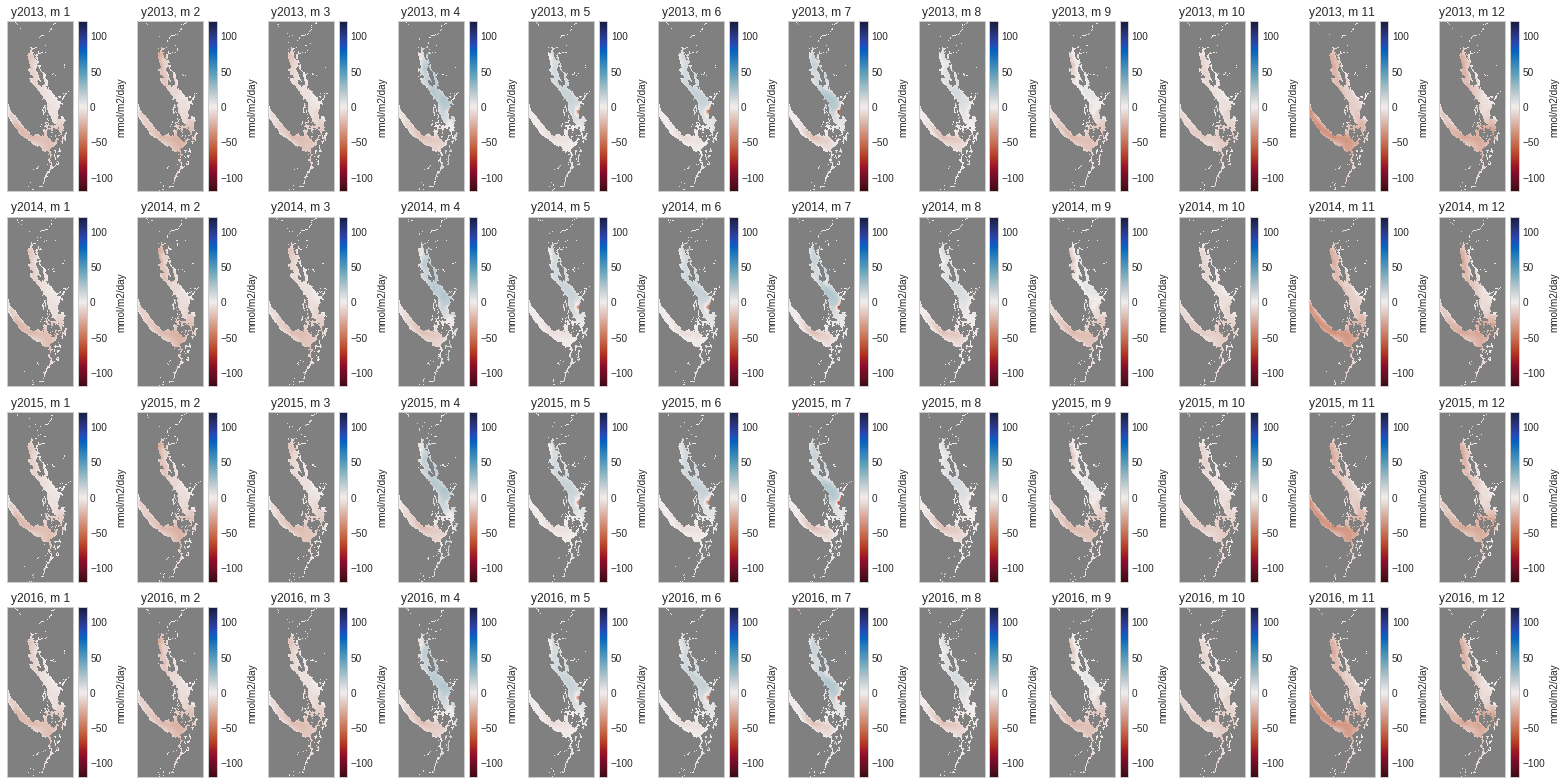

In [30]:
fact = 1.1
fig, axs = plt.subplots(4,12, figsize=(20*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    tax = axs[i]
    viz_tools.set_aspect(tax)
    mesh = tax.pcolormesh(co2flx_2013.co2flux[i,:,:], cmap=cm.cm.balance_r, vmin=-120, vmax=120)
    tax.set_xticks([])
    tax.set_yticks([])
    cbar = plt.colorbar(mesh, ax = tax)
    cbar.set_label('mmol/m2/day')
    tax.set_title(f'y2013, m {i+1}')
    viz_tools.plot_land_mask(tax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'grey')
    
for i in range(0,12):
    tax = axs[i+12]
    viz_tools.set_aspect(tax)
    mesh = tax.pcolormesh(co2flx_2014.co2flux[i,:,:], cmap=cm.cm.balance_r, vmin=-120, vmax=120)
    tax.set_xticks([])
    tax.set_yticks([])
    cbar = plt.colorbar(mesh, ax = tax)
    cbar.set_label('mmol/m2/day')
    tax.set_title(f'y2014, m {i+1}')
    viz_tools.plot_land_mask(tax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'grey')

for i in range(0,12):
    tax = axs[i+24]
    viz_tools.set_aspect(tax)
    mesh = tax.pcolormesh(co2flx_2014.co2flux[i,:,:], cmap=cm.cm.balance_r, vmin=-120, vmax=120)
    tax.set_xticks([])
    tax.set_yticks([])
    cbar = plt.colorbar(mesh, ax = tax)
    cbar.set_label('mmol/m2/day')
    tax.set_title(f'y2015, m {i+1}')
    viz_tools.plot_land_mask(tax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'grey')
    
for i in range(0,12):
    tax = axs[i+36]
    viz_tools.set_aspect(tax)
    mesh = tax.pcolormesh(co2flx_2014.co2flux[i,:,:], cmap=cm.cm.balance_r, vmin=-120, vmax=120)
    tax.set_xticks([])
    tax.set_yticks([])
    cbar = plt.colorbar(mesh, ax = tax)
    cbar.set_label('mmol/m2/day')
    tax.set_title(f'y2016, m {i+1}')
    viz_tools.plot_land_mask(tax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'grey')
    
plt.tight_layout()

fig.savefig('./SalishSeaCast201905_2013-2016_co2flux_monthly.jpg')

# get climatology

In [40]:
climatology_co2flux_r = np.zeros([4,12,898,398])

climatology_co2flux_r[0,:,:,:] = co2flx_2013.co2flux[:,:,:]
climatology_co2flux_r[1,:,:,:] = co2flx_2014.co2flux[:,:,:]
climatology_co2flux_r[2,:,:,:] = co2flx_2015.co2flux[:,:,:]
climatology_co2flux_r[3,:,:,:] = co2flx_2016.co2flux[:,:,:]

climatology_co2flux = np.nanmean(climatology_co2flux_r, axis = 0)

co2flux_xr = co2flx_2013.co2flux.copy(deep=True, data=None)
co2flux_xr[:,:,:] = climatology_co2flux


co2flux_xr.name = 'co2flux'
co2flux_xr.attrs=dict(
        description="201905 monthly co2 flux climatology, years 2013-2016, asselin correction applied (1.11)",
        units="mmol/m2/day",
    )
co2flux_xr.to_netcdf('SalishSeaCast201905_co2flux_monthly_yrs2013-2016.nc')

In [41]:
co2flux_clim = xr.open_dataset('SalishSeaCast201905_co2flux_monthly_yrs2013-2016.nc')

### visualize final climatology

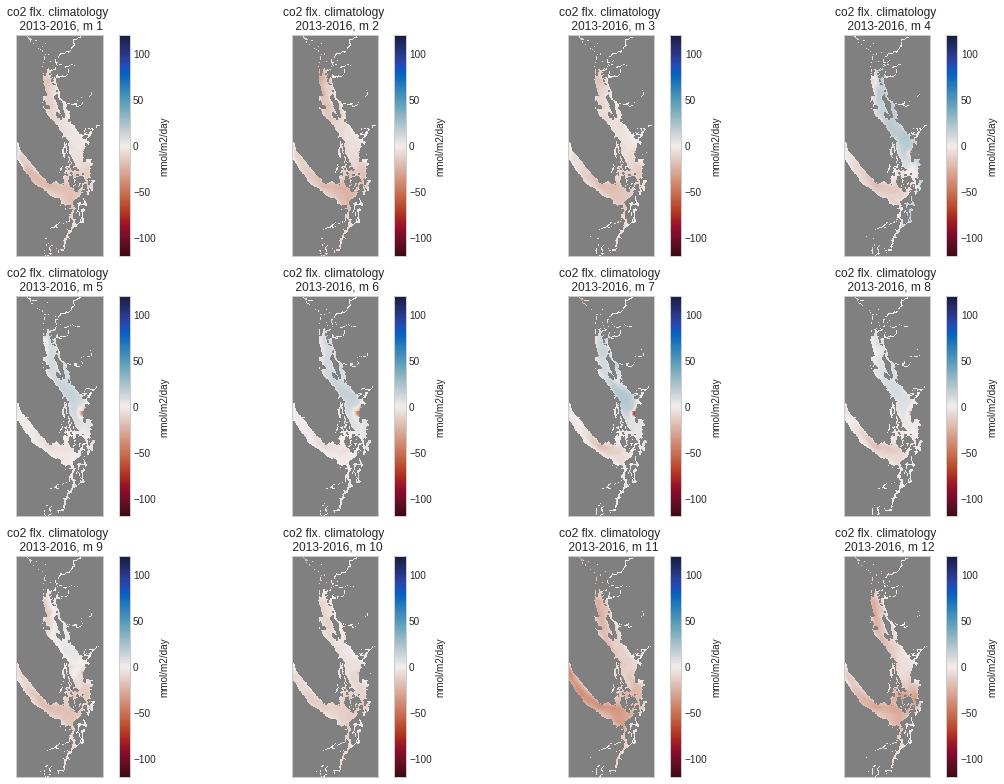

In [47]:
fact = 1.1
fig, axs = plt.subplots(3,4, figsize=(15*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    tax = axs[i]
    viz_tools.set_aspect(tax)
    mesh = tax.pcolormesh(co2flux_clim.co2flux[i,:,:], cmap=cm.cm.balance_r, vmin=-120, vmax=120)
    tax.set_xticks([])
    tax.set_yticks([])
    cbar = plt.colorbar(mesh, ax = tax)
    cbar.set_label('mmol/m2/day')
    tax.set_title(f'co2 flx. climatology \n 2013-2016, m {i+1}')
    viz_tools.plot_land_mask(tax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'grey')
    
plt.tight_layout()
fig.savefig('./SalishSeaCast201905_2013-2016_climatology_co2flux_monthly.jpg')